In [1]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import sklearn
import data_process
import define_model

In [9]:
import h5py
# load data
s_sr = h5py.File("data/LHCO_pointcloud/events_s_sr.h5")
s_br = h5py.File("data/LHCO_pointcloud/events_s_br.h5")
b_sr = h5py.File("data/LHCO_pointcloud/events_b_sr.h5")
b_br = h5py.File("data/LHCO_pointcloud/events_b_br.h5")
ex_bg1 = h5py.File("data/LHCO_pointcloud/extra_bg1.h5")
ex_bg2 = h5py.File("data/LHCO_pointcloud/extra_bg2.h5")

In [10]:
def prepare_jets(data, mjjmin=3.3, mjjmax=3.7):
    # make np array
    prejet1 = np.array(data["jet1_PFCands"])
    m_prej1 = np.array(data["jet_kinematics"][:, 5])
    prejet2 = np.array(data["jet2_PFCands"])
    m_prej2 = np.array(data["jet_kinematics"][:, 9])
    label = np.array(data["truth_label"])
    mjj = np.array(data["jet_kinematics"][:, 0])
    mjj = mjj/1000
    # mjj = np.resize(mjj, (len(mjj), 1))

    # reshape to (, 200 , 3) 
    prejet1 = np.resize(prejet1, (len(prejet1), 100, 3))
    prejet2 = np.resize(prejet2, (len(prejet2), 100, 3))

    # sort jets
    for i in range(len(prejet1)):
        hold = np.array([])
        if (m_prej1[i]<m_prej2[i]):
            hold = prejet1[i]
            prejet1[i] = prejet2[i]
            prejet2[i] = hold

    # make jet labels
    jet1 = np.concatenate((prejet1, np.zeros((len(prejet1), 100, 1))), axis = 2)    
    jet2 = np.concatenate((prejet2, np.ones((len(prejet2), 100, 1))), axis = 2)
    
    full_events = np.concatenate((jet1, jet2), axis=1)

    # mask mjj
    mask = (mjj>mjjmin) & (mjj<mjjmax)
    full_events = full_events[mask]
    label = label[mask]
    return full_events, label

def combine_data(data1, data2):
    x1, y1 = prepare_jets(data1)
    x2, y2 = prepare_jets(data2)
    features = np.concatenate((x1, x2), axis=0)
    label = np.concatenate((y1, y2), axis=0)
    return features, label

def data_label(y, is_data=True):
    y = np.resize(y, (len(y), 1))
    if is_data:
        y = np.concatenate((y, np.ones((len(y), 1))), axis=1)
    else:
        y = np.concatenate((y, np.zeros((len(y), 1))), axis=1)
    return y

In [11]:
# prepare to make datasets
sig, label_sig = combine_data(s_sr, s_br)
bkg, label_bkg = combine_data(b_sr, b_br)
extra1, label_extra1 = prepare_jets(ex_bg1)
extra2, label_extra2 = prepare_jets(ex_bg2)

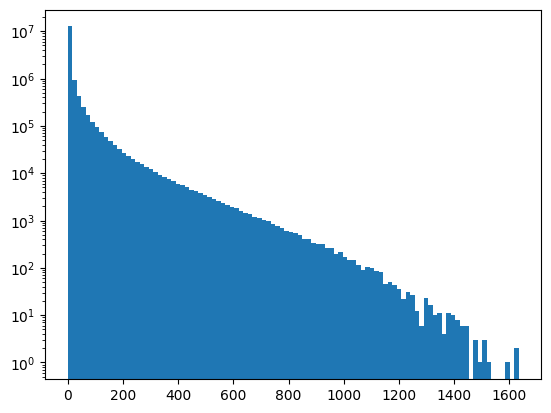

In [16]:
plt.hist(np.ndarray.flatten(sig[:,:,0]), bins=100)
plt.yscale("log")